From: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

# How to Grid Search ARIMA Model Hyperparameters

The ARIMA model for time series analysis and forecasting can be tricky to configure.

There are 3 parameters that require estimation by iterative trial and error from reviewing diagnostic plots and using 40-year-old heuristic rules.

We can automate the process of evaluating a large number of hyperparameters for the ARIMA model by using a grid search procedure.

In this tutorial, you will discover how to tune the ARIMA model using a grid search of hyperparameters in Python.

After completing this tutorial, you will know:

 - A general procedure that you can use to tune the ARIMA hyperparameters for a rolling one-step forecast.
 - How to apply ARIMA hyperparameter optimization on a standard univariate time series dataset.
 - Ideas for extending the procedure for more elaborate and robust models.

## Grid Searching Method

Diagnostic plots of the time series can be used along with heuristic rules to determine the hyperparameters of the ARIMA model.

These are good in most, but perhaps not all, situations.

We can automate the process of training and evaluating ARIMA models on different combinations of model hyperparameters. In machine learning this is called a grid search or model tuning.

In this tutorial, we will develop a method to grid search ARIMA hyperparameters for a one-step rolling forecast.

The approach is broken down into two parts:

1. Evaluate an ARIMA model.
2. Evaluate sets of ARIMA parameters.

The code in this tutorial makes use of the scikit-learn, Pandas, and the statsmodels Python libraries.

## 1. Evaluate ARIMA Model

We can evaluate an ARIMA model by preparing it on a training dataset and evaluating predictions on a test dataset.

This approach involves the following steps:

1. Split the dataset into training and test sets.
2. Walk the time steps in the test dataset.
    1. Train an ARIMA model.
    2. Make a one-step prediction.
    3. Store prediction; get and store actual observation.
3. Calculate error score for predictions compared to expected values.

We can implement this in Python as a new standalone function called *evaluate_arima_model()* that takes a time series dataset as input as well as a tuple with the p, d, and q parameters for the model to be evaluated.

The dataset is split in two: 66% for the initial training dataset and the remaining 34% for the test dataset.

Each time step of the test set is iterated. Just one iteration provides a model that you could use to make predictions on new data. The iterative approach allows a new ARIMA model to be trained each time step.

A prediction is made each iteration and stored in a list. This is so that at the end of the test set, all predictions can be compared to the list of expected values and an error score calculated. In this case, a mean squared error score is calculated and returned.

The complete function is listed below.

In [1]:
import warnings
from pandas import read_csv
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error

Now that we know how to evaluate one set of ARIMA hyperparameters, let’s see how we can call this function repeatedly for a grid of parameters to evaluate.

## 2. Iterate ARIMA Parameters

Evaluating a suite of parameters is relatively straightforward.

The user must specify a grid of p, d, and q ARIMA parameters to iterate. A model is created for each parameter and its performance evaluated by calling the evaluate_arima_model() function described in the previous section.

The function must keep track of the lowest error score observed and the configuration that caused it. This can be summarized at the end of the function with a print to standard out.

We can implement this function called evaluate_models() as a series of four loops.

There are two additional considerations. The first is to ensure the input data are floating point values (as opposed to integers or strings), as this can cause the ARIMA procedure to fail.

Second, the statsmodels ARIMA procedure internally uses numerical optimization procedures to find a set of coefficients for the model. These procedures can fail, which in turn can throw an exception. We must catch these exceptions and skip those configurations that cause a problem. This happens more often then you would think.

Additionally, it is recommended that warnings be ignored for this code to avoid a lot of noise from running the procedure. This can be done as follows:

In [3]:
warnings.filterwarnings("ignore")

The complete procedure for evaluating a grid of ARIMA hyperparameters is listed below.

In [4]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				#print(order)
				try:
					mse = evaluate_arima_model(dataset, order)
					#print(mse)
					if mse < best_score:
						best_score, best_cfg = mse, order
						print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

Now that we have a procedure to grid search ARIMA hyperparameters, let’s test the procedure on two univariate time series problems.

We will start with the Shampoo Sales dataset.



## Shampoo Sales Case Study

The Shampoo Sales dataset describes the monthly number of sales of shampoo over a 3-year period.

The units are a sales count and there are 36 observations. The original dataset is credited to Makridakis, Wheelwright, and Hyndman (1998).

- [Download the dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv).

Download the dataset and place it into your current working directory with the filename *“shampoo-sales.csv“*.

The timestamps in the time series do not contain an absolute year component. We can use a custom date-parsing function when loading the data and baseline the year from 1900, as follows:

In [6]:
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)

Once loaded, we can specify a site of p, d, and q values to search and pass them to the *evaluate_models()* function.

We will try a suite of lag values (p) and just a few difference iterations (d) and residual error lag values (q).

Putting this all together with the generic procedures defined in the previous section, we can grid search ARIMA hyperparameters in the Shampoo Sales dataset.

The complete code example is listed below.

In [7]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5, 6]
d_values = [0, 1]
q_values = [0, 1, 2, 3, 4, 5, 6]
warnings.filterwarnings("ignore")
evaluate_models(series.values.squeeze(), p_values, d_values, q_values)


ARIMA(0, 0, 0) MSE=52425.271
ARIMA(0, 0, 1) MSE=38257.790
ARIMA(0, 0, 2) MSE=23989.679
ARIMA(0, 0, 4) MSE=21007.921
ARIMA(0, 0, 5) MSE=13685.860
ARIMA(0, 1, 1) MSE=10831.968
ARIMA(0, 1, 2) MSE=4671.011
Best ARIMA(0, 1, 2) MSE=4671.011


Running the example prints the ARIMA parameters and MSE for each successful evaluation completed.

The best parameters of ARIMA(0, 1, 2) are reported at the end of the run with a mean squared error of 4671.011

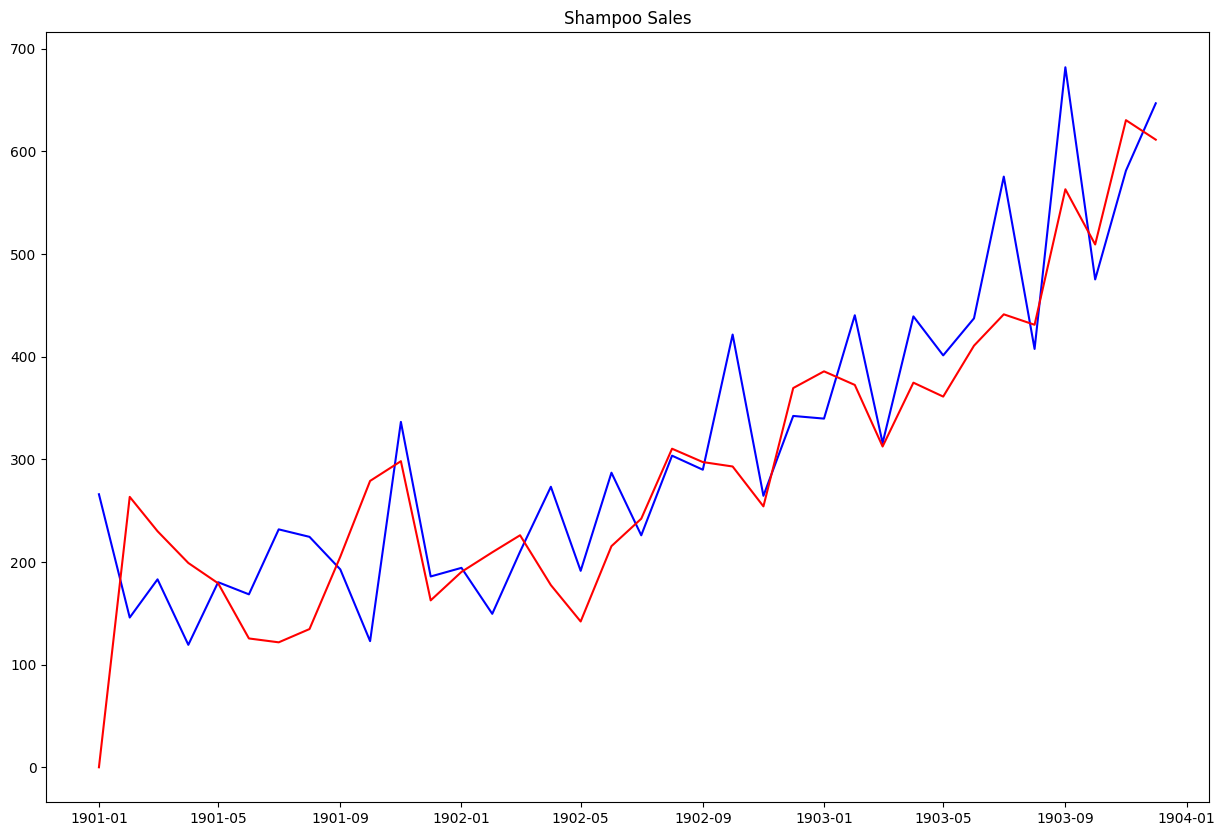

In [ ]:
model_ARIMA = ARIMA(series, order=(0, 1, 2))
results_ARIMA = model_ARIMA.fit()
plt.figure(figsize=(15,10))
plt.plot(series,color='blue')
plt.plot(results_ARIMA.predict(typ='levels'),color='red')
plt.title("Shampoo Sales");

## Extensions

The grid search method used in this tutorial is simple and can easily be extended.

This section lists some ideas to extend the approach you may wish to explore.

 - Seed Grid. The classical diagnostic tools of ACF and PACF plots can still be used with the results used to seed the grid of ARIMA parameters to search.
 - Alternate Measures. The search seeks to optimize the out-of-sample mean squared error. This could be changed to another out-of-sample statistic, an in-sample statistic, such as AIC or BIC, or some combination of the two. You can choose a metric that is most meaningful on your project.
- Residual Diagnostics. Statistics can automatically be calculated on the residual forecast errors to provide an additional indication of the quality of the fit. Examples include statistical tests for whether the distribution of residuals is Gaussian and whether there is an autocorrelation in the residuals.
- Update Model. The ARIMA model is created from scratch for each one-step forecast. With careful inspection of the API, it may be possible to update the internal data of the model with new observations rather than recreating it from scratch.
- Preconditions. The ARIMA model can make assumptions about the time series dataset, such as normality and stationarity. These could be checked and a warning raised for a given of a dataset prior to a given model being trained.